Throughout this project, "progress/accuracy tracking message" for the neural network training process is trimmed out in the final output, as they do not tell much about the results. (I used them for performance check purpose while writing and running the code.)  

**Preliminary setup:**

In [0]:
import torch
import time
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [0]:
use_gpu = True
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'

In [0]:
letter_data = np.float64(np.load("/content/drive/My Drive/cmsc25025_project/letters_data.npy"))[:100000]

digit_data = np.float64(np.load("/content/drive/My Drive/cmsc25025_project/MNIST.npy"))
digit_transform = np.float64(np.load("/content/drive/My Drive/cmsc25025_project/MNIST_TRANSFORM_data.npy"))
digit_label = np.float32(np.load("/content/drive/My Drive/cmsc25025_project/MNIST_labels.npy"))

**Question 3 Part (a):**

Original network (N0) provided for homework 4 is defined below.

In [0]:
class N0(nn.Module):

    def __init__(self,p=0.5,minimizer='Adam'):
      
        super(N0, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p)
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 10)

        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)

        self.first=True
        self.criterion=nn.CrossEntropyLoss()
            
    def forward(self, x):

        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return x
    
    def get_acc_and_loss(self, data, targ):

        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
        
    def run_grad(self,data,targ):

        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct

Architecture of N1, of which sole purpose is embedding training, is defined below.

In [0]:
class N1(nn.Module):

    def __init__(self, p=0.5, minimizer="Adam", simil="cosine"):
      
        super(N1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p)
        self.fc64 = nn.Linear(1024, 64)

        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)

        if simil == "cosine":
            self.criterion = nn.CosineEmbeddingLoss()
          
        else:
            self.criterion = nn.MarginRankingLoss()
            
    def forward(self, x):

        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 1024)
        x = self.fc64(x)

        return x
    
    def get_acc_and_loss(self, data1,data2, targ):

        output1 = self.forward(data1)
        output2 = self.forward(data2)
        loss = self.criterion(output1, output2, targ)
        
        return loss
        
    def run_grad(self,data1,data2,targ):

        loss=self.get_acc_and_loss(data1,data2,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss

**Question 3 Part (b):**  

Random perturbation function is implemented below. For the handwritten alphabets, rotation or flipping could make one letter just look like different letters (N and Z, H and I depending on handwriting style, etc.), so they are not used here.  

In order to verify that this function works as expected, I have experimented with 10 sample handwritten letter images below.  

In [0]:
def affine(x_in, factor):

  nn = x_in.shape[0]
  h = x_in.shape[2]
  w = x_in.shape[3]

  u = ((torch.rand(nn, 6) - 0.5)) * factor
  ID = torch.zeros(nn, 6)
  
  ID[:, 0] = 1
  ID[:, 3] = 1
  ID[:, 4] = 1
  
  theta = (u + ID).reshape(-1, 2, 3)
  grid = F.affine_grid(theta, [nn, 1, h, w], align_corners = True)
  x_out = F.grid_sample(x_in, grid, padding_mode = "zeros", align_corners = True)

  return x_out.type(torch.DoubleTensor)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3316: UserWarning: Since version 1.3.0, affine_grid behavior has changed for unit-size grids when align_corners=True. This is not an intended use case of affine_grid. See the documentation of affine_grid for details.
  warnings.warn("Since version 1.3.0, affine_grid behavior has changed "


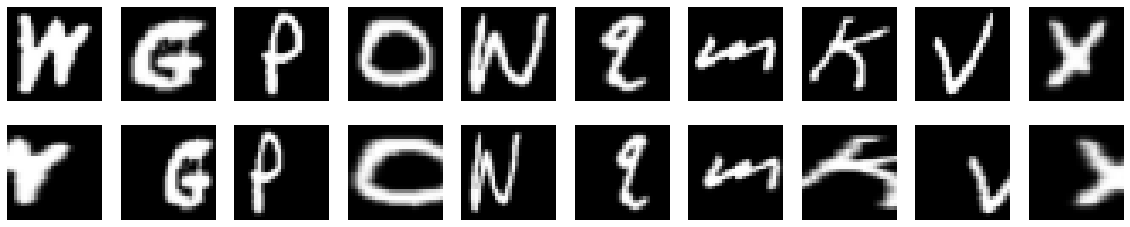

In [0]:
# Used factor 1.5, which seems to be moderately emphasizing the augmentation effects
test = affine(torch.from_numpy(letter_data[:10]).float(), 1.5)
ncols, nrows = 10, 2

plt.figure(figsize = (ncols * 2, nrows * 2))

for i in range(nrows * ncols):

  plt.subplot(nrows, ncols, i + 1)

  if i < 10:
    plt.imshow(letter_data[i, :, :, 0], cmap = "gray")
  
  else:
    plt.imshow(test[i - 10, :, :, 0], cmap = "gray")

  plt.axis("off")
plt.axis("off")
plt.show()

In the above, original images are in the first row and corresponding perturbed images are in the second row. Clearly, we can see that the affine function performs random shifting and scaling, but not flipping or rotations, as expected.

**Question 3 Part (c):**  

The paper used contrastive loss function based on cosine similarity. This is already implemented in the N1 class constructor (in part 3(a)) by using `nn.CosineEmbeddingLoss ` as `self.criterion`.  

**Note:** as mentioned in Question 2, I could have directly implemented the loss function as described in the pseudocode. However, that somehow consumed too much memory and runtime, often causing the session to crash. Therefore, to make the project feasible on my device, I decided to use `nn.CosineEmbeddingLoss `, which is the closest alternative provided by the torch pacakge.  
If I were to manually implement the loss function, it would look as the code below and could be used by setting `self.criterion` to this function's return value in `get_acc_and_loss` of N1.

In [0]:
def cosine_contrastive(x1, x2):
  '''
  Compute cosine similarity-based contrastive loss.

  Credit: discussed with Hee Seung Hwang on the design of this function
  '''
  new = torch.cat((x1, x2), dim = 0)
  norm = F.normalize(new, p = 2, dim = 1)

  # tau here shall be set as a global variable outside
  mat = torch.div(torch.mm(norm, torch.t(norm)), tau)
  mat = torch.exp(mat)

  diag = torch.diag(matrix, diagonal = 0)
  row = torch.sum(mat, dim = 0)
  row = row - diag
  denom = torch.div(mat, row)
  x = -torch.log(denom)

  result = torch.cat((torch.diag(x, diagonal = len(x) // 2), 
                      torch.diag(x, diagonal = -len(x) // 2)), dim = 0)
  
  return torch.mean(result)

**Question 3 Part (d):**  

In order to train the embedding via N1, I first generated perturbations of all 100,000 handwritten letter images. Then, for each minibatch, I passed down a chunk of original images and another chunk of **corresponding** perturbed images as a pair.  
For the binary "target" label ($y\pm1$) required by `nn.CosineEmbeddingLoss`, I used $y=1$ (positive, or similar) for all pairs since we already know that each perturbation image is derived from the original image of corresponding index (thus they should be "similar").



In [0]:
def run_epoch_N1(net, epoch, train1, train2, y, batch_size, num=None, ttype="train", is_cosine = True):
    '''
    Slightly modified run_epoch function of the originally provided code
    so that it would match the construct of N1 class
    '''
    net.train()

    if ttype=='train':
        t1=time.time()
        n=train1[0].shape[0]

        if (num is not None):
            n=np.minimum(n,num)

        train_loss=0; train_correct=0
        
        with tqdm(total=num) as progress_bar:
            for j in np.arange(0,num,batch_size):

                data1 = train1[j:j+batch_size].to(device)
                data2 = train2[j:j+batch_size].to(device)
                targ=torch.from_numpy(y[j:j+batch_size]).type(torch.long).to(device)

                if not is_cosine:
                  targ = targ.unsqueeze(dim = 1)

                loss = net.run_grad(data1, data2, targ)
                train_loss += loss.item()
                
                progress_bar.set_postfix(loss=loss.item())
                progress_bar.update(data1.size(0))
        train_loss /= len(y)
        print('\nTraining set epoch {}: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
            train_loss, train_correct, len(y),
            100. * train_correct / len(y)))

In [0]:
letter_pert = affine(torch.from_numpy(letter_data).float(), 1.5).reshape(100000, 1, 28, 28).float()
letter_data = torch.from_numpy(letter_data.reshape(100000, 1, 28, 28)).float()
y = np.array([1] * 100000)

In [0]:
batch_size, step_size, num_epochs, numtrain = 5000, 0.001, 20, 100000
dropout_p, dim, nchannels = 0.5, 28, 1
minimizer="SGD"
model_name="model"

net1 = N1(p = dropout_p, minimizer="SGD", simil="cosine")
net1.to(device)

N1(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc64): Linear(in_features=1024, out_features=64, bias=True)
  (criterion): CosineEmbeddingLoss()
)

N1 is trained via stochastic gradient descent using SGD optimizer below. Validation step is skipped since classification error / accuracy does not matter at this moment (we will only use the embeddings of N1).

In [0]:
for i in range(num_epochs):
    run_epoch_N1(net1,i,letter_data, letter_pert, y,batch_size, num=numtrain, ttype="train")

**Question 3 Part (e):**  

N2 is defined and N1 embedding parameters are passed down. In order to check that those parameters are working well (as we would anticipate), I trained N2 with the full training set (net2full) and examined its error rates before moving on to Question 4 and train on a small set.

In [0]:
class N2(nn.Module):

    def __init__(self,minimizer='Adam'):
      
        super(N2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc10 = nn.Linear(1024, 10)

        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)

        self.first=True
        self.criterion=nn.CrossEntropyLoss()
            
    def forward(self, x):

        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 1024)
        x = self.fc10(x)

        return x
    
    def get_acc_and_loss(self, data, targ):

        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
        
    def run_grad(self,data,targ):

        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct

In [0]:
net2full = N2(minimizer = "Adam")
net2full.to(device)

params1 = net1.named_parameters()
params2full = net2full.named_parameters()
dict_params2 = dict(params2full)

for name, param in params1:
  if name in dict_params2:
    dict_params2[name].data.copy_(param.data)

net2full.load_state_dict(dict_params2)

<All keys matched successfully>

In [0]:
PP = []

for name, param in net2full.named_parameters():
  if "fc10" in name:
    PP.append(param)

net2full.optimizer = torch.optim.Adam(PP, lr = step_size)

In [0]:
def run_epoch_general(net,epoch,train,batch_size, num=None, ttype="train"):
    
    net.train()

    if ttype=='train':
        t1=time.time()
        n=train[0].shape[0]

        if (num is not None):
            n=np.minimum(n,num)

        ii=np.array(np.arange(0,n,1))
        tr=train[0][ii]
        y=train[1][ii]

        train_loss=0; train_correct=0

        with tqdm(total=len(y)) as progress_bar:
            for j in np.arange(0,len(y),batch_size):
              # Transfer batch data to device (cpu or gpu)
                data=tr[j:j+batch_size].to(device)
                targ=torch.from_numpy(y[j:j+batch_size]).type(torch.long).to(device)
              # Compute gradients, update params and report loss and correct
                loss, correct = net.run_grad(data,targ) 
                
                train_loss += loss.item()
                train_correct += correct.item()
                
                progress_bar.set_postfix(loss=loss.item())
                progress_bar.update(data.size(0))
        train_loss /= len(y)

        train_error.append(100 - (100 * train_correct / len(y)))

        print('\nTraining set epoch {}: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
            train_loss, train_correct, len(y),
            100. * train_correct / len(y)))

In [0]:
def net_test(net,val,batch_size,ttype='val'):

    # Do not apply dropout or gradients.
    net.eval()
    with torch.no_grad():
                test_loss = 0
                test_correct = 0
                vald=val[0]
                yval=val[1]
                for j in np.arange(0,len(yval),batch_size):
                    data=vald[j:j+batch_size].to(device)
                    targ = torch.torch.from_numpy(yval[j:j+batch_size]).type(torch.long).to(device)
                    loss,correct=net.get_acc_and_loss(data,targ)

                    test_loss += loss.item()
                    test_correct += correct.item()

                test_loss /= len(yval)
                SSS='Validation'
                if (ttype=='test'):
                    SSS='Test'
                print('\n{} set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(SSS,
                    test_loss, test_correct, len(yval),
                    100. * test_correct / len(yval)))
                
                eval_error.append(100 - (100 * test_correct / len(yval)))

In [0]:
batch_size, step_size, num_epochs, numtrain = 500, 0.001, 20, 50000
train_error, eval_error = [], []

train_full = (torch.from_numpy(digit_data[:50000].reshape(50000, 1, 28, 28)).float(), digit_label[:50000])
val_full = (torch.from_numpy(digit_data[50000:60000].reshape(10000, 1, 28, 28)).float(), digit_label[50000:60000])
test_full = (torch.from_numpy(digit_data[60000:].reshape(10000, 1, 28, 28)).float(), digit_label[60000:])

for i in range(num_epochs):
    run_epoch_general(net2full,i,train_full,batch_size, num=numtrain, ttype="train")
    net_test(net2full,val_full,batch_size)

In [0]:
print("Error rates for the final epoch are:\n{:f}% on the training set and {:f}% on the validation set.".format(
    train_error[-1], eval_error[-1]))

Error rates for the final epoch are:
2.854000% on the training set and 4.110000% on the validation set.


With N1 embedding parameters and trained using the full training set, N2 recorded approx. 2.85% training error rate and 4.11% validation error rate in the final epoch.  
The error rates are indeed low, so I conclude that embedding parameters passed down from N1 are performing satisfactorily. 

**Question 4:**  

N2, with N1 embedding parameters again, is trained on the small training set (net2small) below.

In [0]:
net2small = N2(minimizer = "Adam")
net2small.to(device)

params2small = net2small.named_parameters()
dict_params2_small = dict(params2small)

for name, param in params1:
  if name in dict_params2_small:
    dict_params2_small[name].data.copy_(param.data)

net2small.load_state_dict(dict_params2)

<All keys matched successfully>

In [0]:
PP = []

for name, param in net2small.named_parameters():
  if "fc10" in name:
    PP.append(param)

net2small.optimizer = torch.optim.Adam(PP, lr = step_size)

In [0]:
# first 1000 datapoints in training, validation, and test set, respectively
train_small = (torch.from_numpy(digit_data[:1000].reshape(1000, 1, 28, 28)).float(), digit_label[:1000])
val_small = (torch.from_numpy(digit_data[50000:51000].reshape(1000, 1, 28, 28)).float(), digit_label[50000:51000])
test_small = (torch.from_numpy(digit_data[60000:61000].reshape(1000, 1, 28, 28)).float(), digit_label[60000:61000])

In [0]:
batch_size, step_size, num_epochs, numtrain = 100, 0.001, 20, 1000
train_error, eval_error = [], []

for i in range(num_epochs):
    run_epoch_general(net2small,i,train_small,batch_size, num=numtrain, ttype="train")
    net_test(net2small,val_small,batch_size)

train_error_N2small = train_error[:]
eval_error_N2small = eval_error[:]

Similarly, N0 is trained on the small training set below.

In [0]:
net0 = N0(minimizer = "Adam")
net0.to(device)

batch_size, step_size, num_epochs, numtrain = 100, 0.001, 20, 1000
train_error, eval_error = [], []

for i in range(num_epochs):
    run_epoch_general(net0,i,train_small,batch_size, num=numtrain, ttype="train")
    net_test(net0,val_small,batch_size)

train_error_N0 = train_error[:]
eval_error_N0 = eval_error[:]

First, we could compare test set error (i.e. accuracy rate) for both N2 (net2small) and N0 (net0):

In [0]:
print("N2 testing set result:")
net_test(net2small,test_small,batch_size,ttype='test')

N2 testing set result:

Test set: Avg. loss: 0.0033, Accuracy: 957/1000 (96%)



In [0]:
print("N0 testing set result")
net_test(net0,test_small,batch_size,ttype='test')

N0 testing set result

Test set: Avg. loss: 0.0024, Accuracy: 925/1000 (92%)



From above, we can see that while both N2 and N0 performed well on the MNIST test set (error rates less than 10%), N2 outperformed N0 by 4% in terms of accuracy (or error) rate, which is a noticeable difference given that both are decent classifiers with 90%+ accuracy.

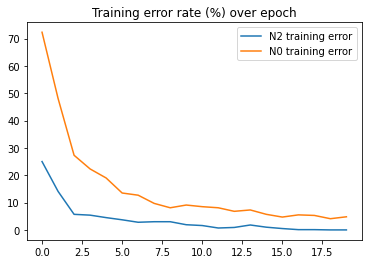

In [0]:
plt.plot(train_error_N2small)
plt.plot(train_error_N0)
plt.legend(["N2 training error", "N0 training error"])
plt.title("Training error rate (%) over epoch")
plt.show()

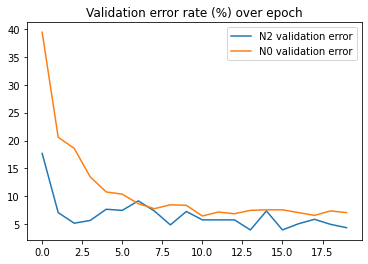

In [0]:
plt.plot(eval_error_N2small)
plt.plot(eval_error_N0)
plt.legend(["N2 validation error", "N0 validation error"])
plt.title("Validation error rate (%) over epoch")
plt.show()

Furthermore, above plots show that N2 almost always recorded lower error rates than N0, both on training and validation set, for most numbers of epoch. Therefore, we can certainly confirm that N2 performs (i.e. "generalizes") better.  

This would be because the embedding of N2 is trained based on handwritten letters, including perturbations. As there are more types of alphabets than digits (26 vs. 10, or 52 if uppercase and lowercase are counted separately), embedding layer would have been trained better to record various features of handwritten characters, including but not limited to directions of strokes, curvature, etc. Moreover, thanks to the perturbations in the training set, N2 embedding would also have been "used to" irregularities that can happen in human handwriting.  

Such intensive training on greater variety and irregularities in handwriting patterns would have allowed N2 to better process handwritten digits as well, resulting in better performance than N0, which was directly trained on digits images.

**Question 5:**

For random initialization, each parameter value is drawn from the standard normal distribution below:

In [0]:
dict_params2_rand = dict_params2.copy()

for name in dict_params2_rand:
  w = torch.empty(dict_params2_rand[name].shape)
  nn.init.normal_(w)
  dict_params2_rand[name] = w

With randomly drawn parameters above, N2 is trained on the small training set (1,000 datapoints) below:

In [0]:
net2rand_small = N2(minimizer = "Adam")
net2rand_small.to(device)

net2rand_small.load_state_dict(dict_params2_rand)

<All keys matched successfully>

In [0]:
PP = []

for name, param in net2rand_small.named_parameters():
  if "fc10" in name:
    PP.append(param)

net2rand_small.optimizer = torch.optim.Adam(PP, lr = step_size)

In [0]:
batch_size, step_size, num_epochs, numtrain = 100, 0.001, 20, 1000
train_error, eval_error = [], []

for i in range(num_epochs):
    run_epoch_general(net2rand_small,i,train_small,batch_size, num=numtrain, ttype="train")
    net_test(net2rand_small,val_small,batch_size)

train_error_N2rand_small = train_error[:]
eval_error_N2rand_small = eval_error[:]

Similarly, with the same randomly drawn parameters, another N2 network is trained on the full training set:

In [0]:
net2rand_full = N2(minimizer = "Adam")
net2rand_full.to(device)

net2rand_full.load_state_dict(dict_params2_rand)

<All keys matched successfully>

In [0]:
PP = []

for name, param in net2rand_full.named_parameters():
  if "fc10" in name:
    PP.append(param)

net2rand_full.optimizer = torch.optim.Adam(PP, lr = step_size)

In [0]:
batch_size, step_size, num_epochs, numtrain = 500, 0.001, 20, 50000
train_error, eval_error = [], []

for i in range(num_epochs):
    run_epoch_general(net2rand_full,i,train_full,batch_size, num=numtrain, ttype="train")
    net_test(net2rand_full,val_full,batch_size)

train_error_N2rand_full = train_error[:]
eval_error_N2rand_full = eval_error[:]

In [0]:
print("N2rand (small training set) test result")
net_test(net2rand_small,test_small,batch_size,ttype='test')

N2rand (small training set) test result

Test set: Avg. loss: 259.0887, Accuracy: 337/1000 (34%)



In [0]:
print("N2rand (full training set) test result")
net_test(net2rand_full,test_full,batch_size,ttype='test')

N2rand (full training set) test result

Test set: Avg. loss: 25.9439, Accuracy: 8867/10000 (89%)



From above, we can check that N2rand performed surely worse than N0 or N2, recording < 90% accuracy or 10%+ error rates.  

Besides being worse than N0 and N2, we can also see that while N2rand's accuracy with small training set was horrible, its performance on the full training set was not really bad (89% accuracy). This would be most probably because greater training set and more repetition by batches provided the model to self-correct noises from random parameters in the embedding layer.  
To further scrutinize this aspect, plots on training and validation error rates are included below:

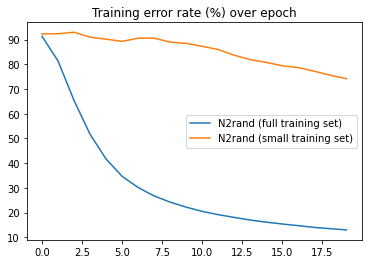

In [0]:
plt.plot(train_error_N2rand_full)
plt.plot(train_error_N2rand_small)
plt.legend(["N2rand (full training set)", "N2rand (small training set)"])
plt.title("Training error rate (%) over epoch")
plt.show()

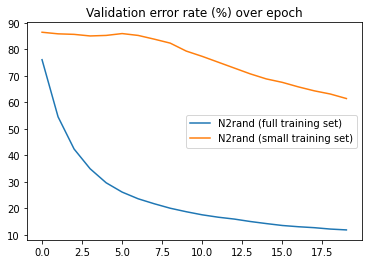

In [0]:
plt.plot(eval_error_N2rand_full)
plt.plot(eval_error_N2rand_small)
plt.legend(["N2rand (full training set)", "N2rand (small training set)"])
plt.title("Validation error rate (%) over epoch")
plt.show()

Above plots tell us that N2rand's training and validation error rates have been decreasing, both for small and full training sets. This indeed provides further evidence for the hypothesis of self-correction through repetitive learning.  

Therefore, we can expect that even though embedding is "messed up" with random parameters that are totally irrelevant with samples (and is fixed to those values), sufficiently large training data and repetitive training could optimize the classifying layer, so that it can "filter out" irrelevant noises from the embedding layer and make reasonable predictions.

**Question 6:**  

Each of N0, N2 (small training set), N2 (full training set), N2rand (small training set), and N2rand (full training set) are tested on the entire transforemd data set:

In [0]:
transform_total_test = (torch.from_numpy(digit_transform.reshape(70000, 1, 28, 28)).float(), digit_label)

In [0]:
print("N0 transformed data test result")
net_test(net0,transform_total_test,batch_size,ttype='test')

N0 transformed data test result

Test set: Avg. loss: 0.0056, Accuracy: 35535/70000 (51%)



In [0]:
print("N2 (small training set) transformed data test result")
net_test(net2small,transform_total_test,batch_size,ttype='test')

N2 (small training set) transformed data test result

Test set: Avg. loss: 0.0162, Accuracy: 39425/70000 (56%)



In [0]:
print("N2 (full training set) transformed data test result")
net_test(net2full,transform_total_test,batch_size,ttype='test')

N2 (full training set) transformed data test result

Test set: Avg. loss: 0.0127, Accuracy: 39339/70000 (56%)



In [0]:
print("N2rand (small training set) transformed data test result")
net_test(net2rand_small,transform_total_test,batch_size,ttype='test')

N2rand (small training set) transformed data test result

Test set: Avg. loss: 607.3399, Accuracy: 14464/70000 (21%)



In [0]:
print("N2rand (full training set) transformed data test result")
net_test(net2rand_full,transform_total_test,batch_size,ttype='test')

N2rand (full training set) transformed data test result

Test set: Avg. loss: 482.1826, Accuracy: 26905/70000 (38%)



Here, N2rand's recorded < 50% accuracy rates, while N0 and N2's recorded accuracy rates between 50% and 60%. Hence, we can see that all those networks did not perform very well on the transformed data.  

In particular, it seems most likely that proper prediction based on transformed data requires well-suited embedding: while N0 and N2's recorded relatively fair (approx. 50%) accuracy, N2rand's with randomly drawn embedding parameters showed horrible accuracy rates.  
Also, some set of digits are often hard to distinguish depending on a person's handwriting (e.g. 1 and 7; 6, 8, and 9). With transformation, it would have been even harder to distinguish such digits.  

More fundamentally, as the transformation includes, a number of images do not fully capture the digits. That would possibly have caused further confusion to the network, as some digits just look like others if a part of them are cropped out (e.g. 6 will look like 5 and 8 like 3, if their left half is delted).

For reference, 100 samples of ransformed digit images are inspected below:

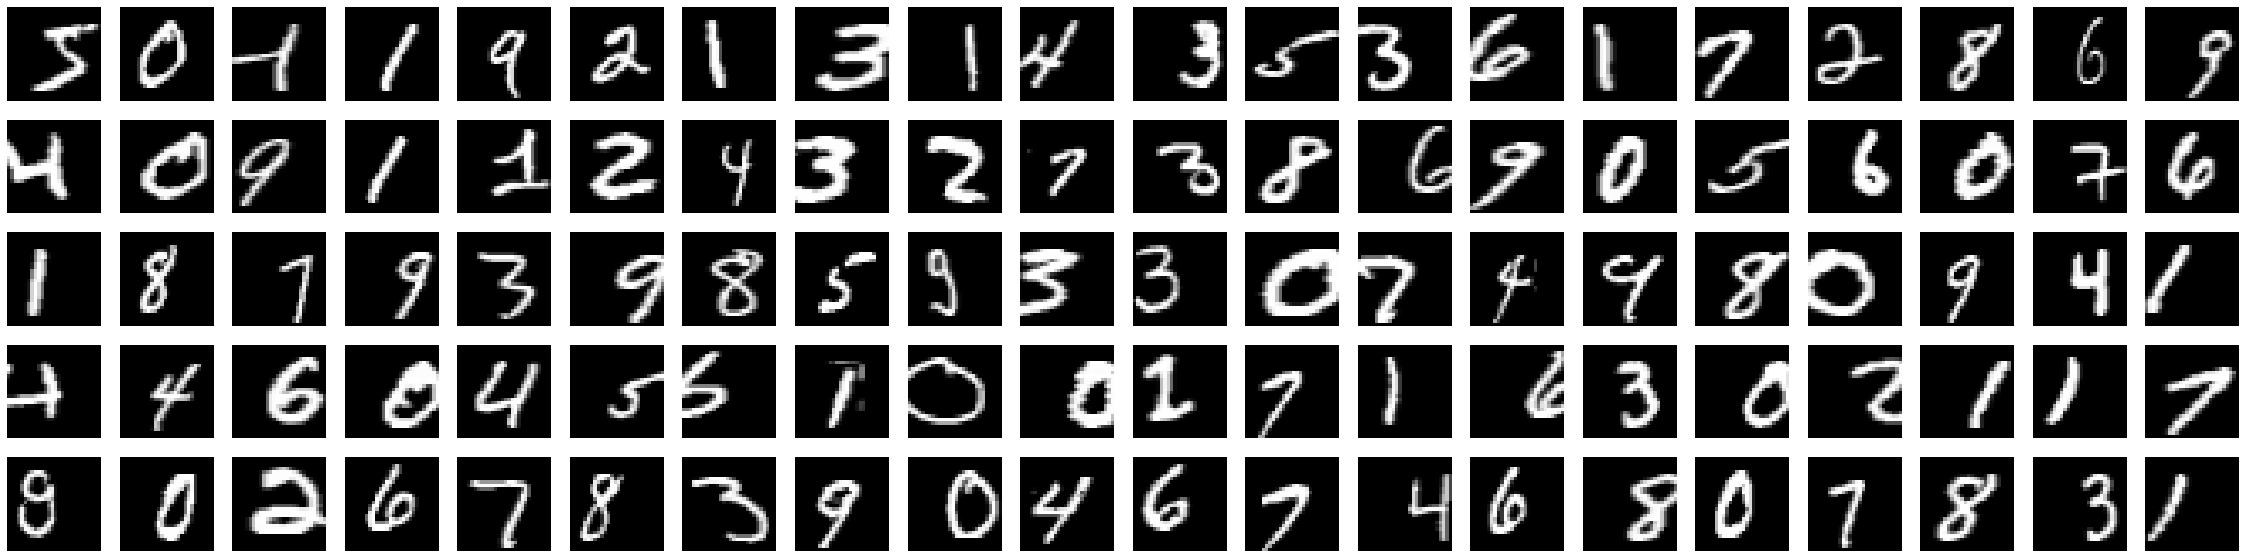

In [0]:
ncols, nrows = 20, 5

plt.figure(figsize = (ncols * 2, nrows * 2))

for i in range(nrows * ncols):

  plt.subplot(nrows, ncols, i + 1)
  plt.imshow(digit_transform[i, :, :, 0], cmap = "gray")
  plt.axis("off")

plt.axis("off")
plt.show()

Hecne, we could try different approaches, including other loss functions and more extensive training with perturbations, while **sticking to the non-random embedding.**

**Question 7 Part (a):**

In Question 2, I proposed to base the contrastive loss on Euclidean distance instead of cosine similarity. This is already implemented in N1 and can be used by passing down parameter `simil="euclidean"`  (or technically, not passing down `simil="cosine"`) to the constructor of N1.

In [0]:
batch_size, step_size, num_epochs, numtrain = 5000, 0.001, 20, 100000
dropout_p, dim, nchannels = 0.5, 28, 1
minimizer="SGD"
model_name="model"

net1_euclidean = N1(p = dropout_p, minimizer="SGD", simil="euclidean")
net1_euclidean.to(device)

N1(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc64): Linear(in_features=1024, out_features=64, bias=True)
  (criterion): MarginRankingLoss()
)

In [0]:
for i in range(num_epochs):
    run_epoch_N1(net1_euclidean,i,letter_data, letter_pert, y,batch_size, num=numtrain, ttype="train", is_cosine=False)

In [0]:
net2_euclidean = N2(minimizer = "Adam")
net2_euclidean.to(device)

params1_euclidean = net1_euclidean.named_parameters()
params2_euclidean = net2_euclidean.named_parameters()
dict_params2_euclidean = dict(params2_euclidean)

for name, param in params1_euclidean:
  if name in dict_params2_euclidean:
    dict_params2_euclidean[name].data.copy_(param.data)

net2_euclidean.load_state_dict(dict_params2_euclidean)

<All keys matched successfully>

In [0]:
PP = []

for name, param in net2_euclidean.named_parameters():
  if "fc10" in name:
    PP.append(param)

net2_euclidean.optimizer = torch.optim.Adam(PP, lr = step_size)

In [0]:
batch_size, step_size, num_epochs, numtrain = 500, 0.001, 20, 50000
train_error, eval_error = [], [] #

transform_val = (torch.from_numpy(digit_transform[:10000].reshape(10000, 1, 28, 28)).float(), digit_label[:10000])
transform_test = (torch.from_numpy(digit_transform[10000:].reshape(60000, 1, 28, 28)).float(), digit_label[10000:])

for i in range(num_epochs):
    run_epoch_general(net2_euclidean,i,train_full,batch_size, num=numtrain, ttype="train")
    net_test(net2_euclidean,transform_val,batch_size)

train_error_N2euclidean = train_error[:]
eval_error_N2euclidean = eval_error[:]

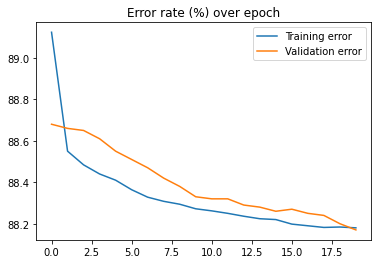

In [0]:
plt.plot(train_error_N2euclidean)
plt.plot(eval_error_N2euclidean)
plt.legend(["Training error", "Validation error"])
plt.title("Error rate (%) over epoch")
plt.show()

From the above plot, we can see that both training and validation error rates are very high and not improving to a meaningful extent over epoch. (Although they are technically decreasing, slopes are close to 0 - check the y-axis range carefully!)

In [0]:
print("N2 (Euclidean distance-based) transformed data test result")
net_test(net2_euclidean,transform_test,batch_size,ttype='test')

N2 (Euclidean distance-based) transformed data test result

Test set: Avg. loss: 0.0046, Accuracy: 7166/60000 (12%)



Furthermore, transformed data testing result is disappointing (< 20% accuracy / 80%+ error rate). Thus, we shall conclude that usage of Euclidean distance-based contrastive loss is not a good alternative of cosine similairty-based loss.

**Question 7 Part (b):**  

The function `new_affine` is defined below, which applies the full affine map to the grid (beyond shifting and scaling).

In [0]:
def new_affine(x_in, factor):

  nn = x_in.shape[0]
  h = x_in.shape[2]
  w = x_in.shape[3]

  u = ((torch.rand(nn, 6) - 0.5)) * factor
  ID = torch.zeros(nn, 6)
  ID[:, 0] = 1
  ID[:, 4] = 1
  theta = (u + ID).reshape(-1, 2, 3)

  grid = F.affine_grid(theta, [nn, 1, h, w], align_corners = True)
  x_out = F.grid_sample(x_in, grid, padding_mode = "zeros", align_corners = True)

  return x_out.type(torch.DoubleTensor)

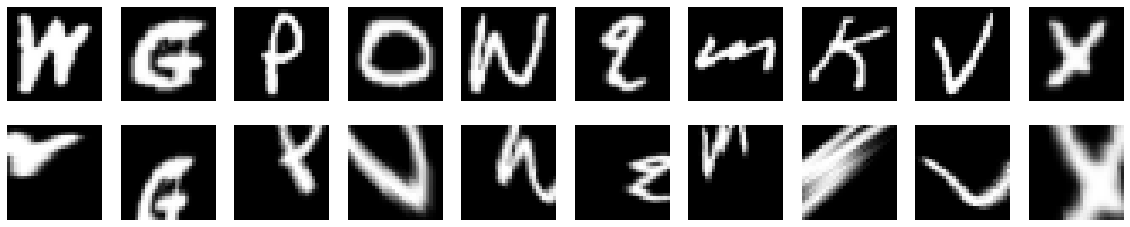

In [0]:
test = new_affine(letter_data[:10].float(), 1.2)
ncols, nrows = 10, 2

plt.figure(figsize = (ncols * 2, nrows * 2))

for i in range(nrows * ncols):

  plt.subplot(nrows, ncols, i + 1)

  if i < 10:
    plt.imshow(letter_data[i, 0, :, :], cmap = "gray")
  
  else:
    plt.imshow(test[i - 10, 0, :, :], cmap = "gray")

  plt.axis("off")
plt.axis("off")
plt.show()

In the above, the first raw has the original images and the second row has perturbated ones. As observable, this function ideed applies full affine map, including rotation.  

N1 embedding is trained below using this version of augmentation:

In [0]:
batch_size, step_size, num_epochs, numtrain = 5000, 0.001, 20, 100000
dropout_p, dim, nchannels = 0.5, 28, 1
minimizer="SGD"
model_name="model"

net1_fullaffine = N1(p = dropout_p, minimizer="SGD", simil="cosine")
net1_fullaffine.to(device)

N1(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc64): Linear(in_features=1024, out_features=64, bias=True)
  (criterion): CosineEmbeddingLoss()
)

In [0]:
letter_fullaffine = new_affine(letter_data.reshape(100000, 28, 28, 1), 1.5).reshape(100000, 1, 28, 28).float()

In [0]:
for i in range(num_epochs):
    run_epoch_N1(net1_fullaffine,i,letter_data, letter_fullaffine, y,batch_size, num=numtrain, ttype="train", is_cosine=True)

In [0]:
net2_fullaffine = N2(minimizer = "Adam")
net2_fullaffine.to(device)

params1_fullaffine = net1_fullaffine.named_parameters()
params2_fullaffine = net2_fullaffine.named_parameters()
dict_params2_fullaffine = dict(params2_fullaffine)

for name, param in params1_fullaffine:
  if name in dict_params2_fullaffine:
    dict_params2_fullaffine[name].data.copy_(param.data)

net2_fullaffine.load_state_dict(dict_params2_fullaffine)

<All keys matched successfully>

In [0]:
PP = []

for name, param in net2_fullaffine.named_parameters():
  if "fc10" in name:
    PP.append(param)

net2_fullaffine.optimizer = torch.optim.Adam(PP, lr = step_size)

In [0]:
batch_size, step_size, num_epochs, numtrain = 500, 0.001, 20, 50000
train_error, eval_error = [], [] #

for i in range(num_epochs):
    run_epoch_general(net2_fullaffine,i,train_full,batch_size, num=numtrain, ttype="train")
    net_test(net2_fullaffine,transform_val,batch_size)

train_error_N2fullaffine = train_error[:]
eval_error_N2fullaffine = eval_error[:]

In [0]:
print("N2 (trained with full-affine perturbations) transformed data test result")
net_test(net2_fullaffine,transform_test,batch_size,ttype='test')

N2 (trained with full-affine perturbations) transformed data test result

Test set: Avg. loss: 0.0130, Accuracy: 33601/60000 (56%)



From above, we see that the test set error rate is still between 50% and 60%, which did not really improve from the model experimented with in Question 6. However, validation error graph below still provides some further insight:

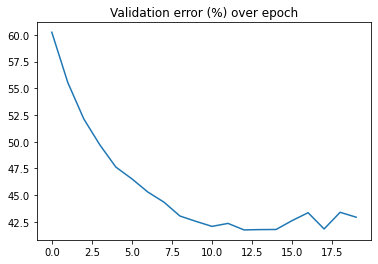

In [0]:
plt.plot(eval_error_N2fullaffine)
plt.title("Validation error (%) over epoch")
plt.show()

From above, while not rapid, we can see that validation error rate has been decreasing with meaningful speed as epoch increased.  
In other words, above plot suggests that if we can secure greater training data and implement greater number of epochs, this approach might be able to further improve prediction accuracy - which is promising to some extent.  

Therefore, while experiments in both 7(a) and 7(b) were not highly successful, their results recommend us to consider usage of full affine map-applied perturbation as training data in order to make our networks more transformation-invariant.